In this notebook, we will illustrate the concept of categorical embeddings using [this data set](https://www.kaggle.com/datafiniti/womens-shoes-prices) from Kaggle. The data set describes a list of 10000 women's shoes and the prices at which they are sold.


In [ ]:
!wget http://mg.bluecourses.com/wp-content/uploads/2020/04/womens-shoes-prices.zip -O womens-shoes-prices.zip

--2020-07-21 13:22:00--  http://mg.bluecourses.com/wp-content/uploads/2020/04/womens-shoes-prices.zip
Resolving mg.bluecourses.com (mg.bluecourses.com)... 46.30.215.75
Connecting to mg.bluecourses.com (mg.bluecourses.com)|46.30.215.75|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13736270 (13M) [application/zip]
Saving to: ‘womens-shoes-prices.zip’

womens-shoes-prices 100%[===================>]  13.10M  6.47MB/s    in 2.0s    

2020-07-21 13:22:02 (6.47 MB/s) - ‘womens-shoes-prices.zip’ saved [13736270/13736270]



In [ ]:
!unzip womens-shoes-prices.zip

Archive:  womens-shoes-prices.zip
  inflating: 7210_1.csv              
  inflating: Datafiniti_Womens_Shoes.csv  
  inflating: Datafiniti_Womens_Shoes_Jun19.csv  


In [ ]:
%tensorflow_version 2.x

import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Lambda, Flatten
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.regularizers import l2
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import re
import json

We read in the data set and preprocess it a bit. The data set is pretty complex and contain even a couple of JSON fields, but we're going to keep things simple here and only retain brand, color, manufacturer, price, and merchant:

In [ ]:
data = pd.read_csv('7210_1.csv', low_memory=False)
cols_to_keep = ['brand', 'colors', 'manufacturer', 'prices.amountMin', 'prices.merchant']
data = data.loc[:, cols_to_keep]
data.rename(columns={'prices.amountMin': 'price', 'prices.merchant': 'merchant'}, inplace=True)
data.drop_duplicates(inplace=True)
data.head()

,brand,colors,manufacturer,price,merchant
0,Novica,Purple,NaN,62.99,Overstock.com
6,Novica,Purple,NaN,56.69,Overstock.com
7,Pedi Couture,NaN,Pedi Couture,30.00,Big Deal Hunter - Walmart.com
8,ANNE KLEIN SPORT,NaN,NaN,100.00,ApparelSave - Walmart.com
9,ANNE KLEIN SPORT,NaN,NaN,25.99,ApparelSave - Walmart.com


Note that the `colors` field is formatted as a comma separated string. For those cases where more than one color is given, we only keep the most ocurring color. In addition, we only keep the top-100 colors only. The others, we replace with "OTHER":

In [ ]:
data_colors = data.colors.str.get_dummies(sep=',')
cats_colors = data_colors.apply(lambda x : x.sum(), axis=0)
cats_colors = cats_colors[cats_colors > 100]
data_colors = data_colors.loc[:, cats_colors.index]
data_colors = data_colors.apply(lambda x : str(cats_colors[(x == 1)].idxmax()) if len(cats_colors[(x == 1)]) else 'OTHER', axis=1)

In [ ]:
# Let's see which colors we have:
np.unique(data_colors, return_counts=True)

(array(['Beige', 'Black', 'Blue', 'Brown', 'Gold', 'Gray', 'Green', 'Grey',
        'Multicolor', 'Natural', 'Navy', 'OTHER', 'Off-White', 'Orange',
        'Pink', 'Purple', 'Red', 'Silver', 'Tan', 'Taupe', 'White',
        'Yellow'], dtype=object),
 array([ 363, 4996,  535,  832,  152,  245,  252,  167,  193,   35,   41,
        8041,   29,  116,  229,   79,  253,  430,  123,   24,  565,  109]))

Merge the color column back to the original data set, drop the old one, replace remaining NaN values with "OTHER".

In [ ]:
data_prepared = data.copy()
data_prepared = pd.concat([data_prepared, data_colors], axis=1)
data_prepared.drop(columns=['colors'], inplace=True)
data_prepared.rename(columns={0: 'color'}, inplace=True)
data_prepared.loc[data_prepared.manufacturer.isnull(), 'manufacturer'] = 'OTHER'
data_prepared.loc[data_prepared.merchant.isnull(),     'merchant']     = 'OTHER'
data_prepared['brand']        = data_prepared['brand'].astype(str)
data_prepared['manufacturer'] = data_prepared['manufacturer'].astype(str)
data_prepared['merchant']     = data_prepared['merchant'].astype(str)
data_prepared['color']        = data_prepared['color'].astype(str)
data_prepared.head()

,brand,manufacturer,price,merchant,color
0,Novica,OTHER,62.99,Overstock.com,Purple
6,Novica,OTHER,56.69,Overstock.com,Purple
7,Pedi Couture,Pedi Couture,30.00,Big Deal Hunter - Walmart.com,OTHER
8,ANNE KLEIN SPORT,OTHER,100.00,ApparelSave - Walmart.com,OTHER
9,ANNE KLEIN SPORT,OTHER,25.99,ApparelSave - Walmart.com,OTHER


We're not done yet, as scikit-learn expects dummies as it cannot work with categoricals directly. Luckily, Pandas provides a `get_dummies` method which can help us here.

In [ ]:
data_prepared_dummies = pd.get_dummies(data_prepared)

X = data_prepared_dummies.copy().drop(columns='price')
y = data_prepared_dummies.price

X_train, X_test, y_train, y_test = train_test_split(X, y)

We can now train an e.g. random forest regression model and see how well it does:

In [ ]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

MSE of random forest without embeddings = 6771.374373534266


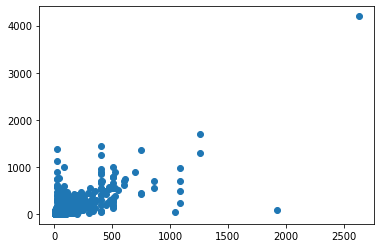

In [ ]:
rf_mse = np.sum((rf_preds - y_test)**2) / len(rf_preds)
print('MSE of random forest without embeddings =', rf_mse)
plt.scatter(rf_preds, y_test)

We now start from the same train and test set, but utilizing the prepared undummified data set to create our embeddings...

In [ ]:
X_train_orig = data_prepared.loc[X_train.index, :].drop(columns='price')
X_test_orig  = data_prepared.loc[X_test.index,  :].drop(columns='price')

We define a helper function to convert a series of strings to integers which can be fitted on a train series and applied on a test series:

In [ ]:
def to_integer(cat_series, categories=None):
  if categories is None:
    categories = list(np.unique(cat_series))
  return categories, np.array([categories.index(val) if val in categories else categories.index('OTHER') for val in cat_series])

In [ ]:
to_integer(X_train_orig.color)

(['Beige',
  'Black',
  'Blue',
  'Brown',
  'Gold',
  'Gray',
  'Green',
  'Grey',
  'Multicolor',
  'Natural',
  'Navy',
  'OTHER',
  'Off-White',
  'Orange',
  'Pink',
  'Purple',
  'Red',
  'Silver',
  'Tan',
  'Taupe',
  'White',
  'Yellow'],
 array([11, 11,  3, ..., 11, 20, 11]))

We also define a function to help us train our embeddings. We will use a limited embedding size of 2 for each feature:

In [ ]:
def train_embeddings(X_train, X_test, y_train, y_test, epochs=150, batch_size=512, emb_size=2, categories=None):
  categories, X_train_cat = to_integer(X_train, categories)
  _, X_test_cat           = to_integer(X_test, categories)

  model = Sequential()
  model.add(Embedding(input_dim=X_train_cat.max() + 1, output_dim=emb_size, input_length=1,
                      embeddings_regularizer=l2(0.1)))
  model.add(Flatten())
  model.add(Dense(1, activation='linear'))
  model.compile(loss='mse', optimizer='adam')

  model.fit(X_train_cat, y_train, batch_size=batch_size, epochs=epochs, 
            validation_data=(X_test_cat, y_test), verbose=0)

  return categories, model.weights[0].numpy()

Create our embeddings:

In [ ]:
color_cats,        color_emb        = train_embeddings(X_train_orig.color,        X_test_orig.color,        y_train, y_test)
manufacturer_cats, manufacturer_emb = train_embeddings(X_train_orig.manufacturer, X_test_orig.manufacturer, y_train, y_test)
merchant_cats,     merchant_emb     = train_embeddings(X_train_orig.merchant,     X_test_orig.merchant,     y_train, y_test)
brand_cats,        brand_emb        = train_embeddings(X_train_orig.brand,        X_test_orig.brand,        y_train, y_test, categories=list(np.unique(data_prepared.brand)))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Let's show what our embeddings have learned for e.g. the `color` feature:

[]

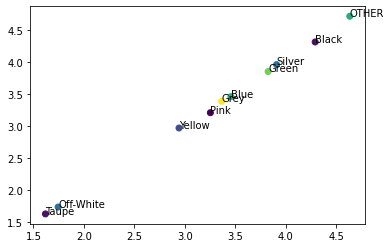

In [ ]:
sample = np.random.choice(list(range(color_emb.shape[0])), size=10, replace=False)
colors = [y_train[X_train_orig.color == color_cats[s]].median() for s in sample]
plt.scatter(color_emb[sample, 0], color_emb[sample, 1], c=colors)

for s in sample:
  plt.text(color_emb[s, 0], color_emb[s, 1], s=color_cats[s])
plt.plot()

We now replace the original feature columns with the embeddings: two features for each original column.

In [ ]:
fetch_cat = lambda cats, c : list(cats).index(c) if c in list(cats) else list(cats).index('OTHER')
pdify     = lambda r, p : pd.DataFrame(r).rename(columns={0: p+'0', 1: p+'1'})

X_train_embeddings = pd.concat([X_train_orig.copy(),
           pdify(X_train_orig.color.apply(lambda x : pd.Series(color_emb[fetch_cat(color_cats, x)])), 'c'),
           pdify(X_train_orig.manufacturer.apply(lambda x : pd.Series(manufacturer_emb[fetch_cat(manufacturer_cats, x)])), 'm'),
           pdify(X_train_orig.merchant.apply(lambda x : pd.Series(merchant_emb[fetch_cat(merchant_cats, x)])), 'e'),
           pdify(X_train_orig.brand.apply(lambda x : pd.Series(brand_emb[fetch_cat(brand_cats, x)])), 'b')
], axis=1).drop(columns=['brand', 'manufacturer', 'merchant', 'color'])

X_test_embeddings = pd.concat([X_test_orig.copy(),
           pdify(X_test_orig.color.apply(lambda x : pd.Series(color_emb[fetch_cat(color_cats, x)])), 'c'),
           pdify(X_test_orig.manufacturer.apply(lambda x : pd.Series(manufacturer_emb[fetch_cat(manufacturer_cats, x)])), 'm'),
           pdify(X_test_orig.merchant.apply(lambda x : pd.Series(merchant_emb[fetch_cat(merchant_cats, x)])), 'e'),
           pdify(X_test_orig.brand.apply(lambda x : pd.Series(brand_emb[fetch_cat(brand_cats, x)])), 'b')
], axis=1).drop(columns=['brand', 'manufacturer', 'merchant', 'color'])

In [ ]:
X_train_embeddings.head()

,c0,c1,m0,m1,e0,e1,b0,b1
3561,4.632943,4.718179,-4.426722,4.268625,-4.384021,4.709066,0.999327,0.935866
8450,4.632943,4.718179,-4.426722,4.268625,-4.384021,4.709066,2.225339,2.242990
25576,4.365063,4.315524,-4.426722,4.268625,-4.310347,4.555201,2.238530,2.260355
14936,3.065131,3.093870,-1.786603,1.804680,-4.384021,4.709066,1.881185,1.841820
7242,4.290141,4.316244,-1.944559,1.985139,-4.384021,4.709066,2.322567,2.372267


And let's train the random forest again:

In [ ]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train_embeddings, y_train)
rf_preds = rf.predict(X_test_embeddings)

MSE of random forest with embeddings = 6618.533937224548


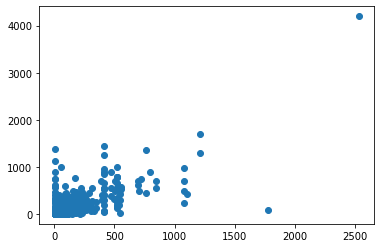

In [ ]:
rf_mse = np.sum((rf_preds - y_test)**2) / len(rf_preds)
print('MSE of random forest with embeddings =', rf_mse)
plt.scatter(rf_preds, y_test)

Things to try:

- We only get a small benefit here from using embeddings, try to see what happens if you increase the dimensionality of the embeddings.